In [1]:
from osdt.osdt import OSDT
from osdt.helpers import visualize_tree, compute_tree_metrics, print_tree_metrics

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
)
from sklearn.model_selection import StratifiedKFold, train_test_split

from ucimlrepo import fetch_ucirepo

### Data & Visualisation

Binary classification

8124 instances

22 features -> 112 features

In [3]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features

In [4]:
expanded_cols = []
X_numeric_pd = X.copy()
for col in X.columns:
    X_numeric_pd[col] = X_numeric_pd[col].astype("category").cat.codes
    # if there is nan in this column, replace it with max + 1
    if X[col].isna().sum() > 0:
        X_numeric_pd[col] = X_numeric_pd[col].replace(
            -1, max(X_numeric_pd[col]) + 1
        )
        expanded_cols.append(col)

# X_numeric_pd

In [5]:
for e in expanded_cols:
    print(f"Column {e} had NaN.\nNow the unique values are: ")
    print(X_numeric_pd[e].unique())

    # check the frequency of each value in the column, including NaN
    print(f"Frequency of each value in the column: ")
    print(X_numeric_pd["stalk-root"].value_counts(dropna=False))

    print("The categories are: ")
    print(X[e].astype("category").cat.categories)

Column stalk-root had NaN.
Now the unique values are: 
[2 1 0 3 4]
Frequency of each value in the column: 
stalk-root
0    3776
4    2480
2    1120
1     556
3     192
Name: count, dtype: int64
The categories are: 
Index(['b', 'c', 'e', 'r'], dtype='object')


In [6]:
def custom_combiner(feature, category):
    # print(f"feature: {feature}")
    # print(f"category: {category}")
    if feature == "feature":
        return "test"
    feature_og_name_dict = dict(
        enumerate(X[feature].astype("category").cat.categories)
    )
    if feature in expanded_cols and category not in feature_og_name_dict:
        return f"{feature}=nan"
    return f"{feature}={feature_og_name_dict[category]}"


ohe = OneHotEncoder(drop="if_binary", feature_name_combiner=custom_combiner)
X_oh_np = ohe.fit_transform(X_numeric_pd.to_numpy()).toarray()
feature_names = ohe.get_feature_names_out(
    input_features=X_numeric_pd.columns.to_list()
)

print(X_oh_np.shape)
print(feature_names)


y_np = np.where(mushroom.data.targets.to_numpy() == "p", 1, 0).flatten()
print(y_np.shape)

(8124, 112)
['cap-shape=b' 'cap-shape=c' 'cap-shape=f' 'cap-shape=k' 'cap-shape=s'
 'cap-shape=x' 'cap-surface=f' 'cap-surface=g' 'cap-surface=s'
 'cap-surface=y' 'cap-color=b' 'cap-color=c' 'cap-color=e' 'cap-color=g'
 'cap-color=n' 'cap-color=p' 'cap-color=r' 'cap-color=u' 'cap-color=w'
 'cap-color=y' 'bruises=t' 'odor=a' 'odor=c' 'odor=f' 'odor=l' 'odor=m'
 'odor=n' 'odor=p' 'odor=s' 'odor=y' 'gill-attachment=f' 'gill-spacing=w'
 'gill-size=n' 'gill-color=b' 'gill-color=e' 'gill-color=g' 'gill-color=h'
 'gill-color=k' 'gill-color=n' 'gill-color=o' 'gill-color=p'
 'gill-color=r' 'gill-color=u' 'gill-color=w' 'gill-color=y'
 'stalk-shape=t' 'stalk-root=b' 'stalk-root=c' 'stalk-root=e'
 'stalk-root=r' 'stalk-root=nan' 'stalk-surface-above-ring=f'
 'stalk-surface-above-ring=k' 'stalk-surface-above-ring=s'
 'stalk-surface-above-ring=y' 'stalk-surface-below-ring=f'
 'stalk-surface-below-ring=k' 'stalk-surface-below-ring=s'
 'stalk-surface-below-ring=y' 'stalk-color-above-ring=b'
 'stalk-c

In [7]:
train_X, hold_out_test_X, train_y, hold_out_test_y = train_test_split(
    X_oh_np, y_np, test_size=0.2, random_state=73, stratify=y_np
)

In [8]:
train_y.mean(), hold_out_test_y.mean()

(0.4820741652561933, 0.48184615384615387)

In [9]:
# check if train_X is only binary values
np.all(np.isin(train_X, [0, 1]))

# convert train_X to int array
train_X = train_X.astype(int)
# convert hold_out_test_X to int array
hold_out_test_X = hold_out_test_X.astype(int)

# convert train_y to int array
train_y = train_y.astype(int)
# convert hold_out_test_y to int array
hold_out_test_y = hold_out_test_y.astype(int)

### Common code

In [10]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [11]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

## OSDT

Model OSDT with 5-fold cross-validation

nrule: 112
ndata: 5199
gr: [1.62760504e-02 4.13178302e-04 3.78398174e-04 1.23144522e-02
 2.06483837e-03 5.38368857e-04 1.79594943e-02 4.13178302e-04
 4.45361575e-03 3.57924195e-03 1.57831456e-03 3.84558809e-04
 5.36717371e-03 9.11965532e-04 1.97442812e-03 1.07974688e-03
 1.07502235e-03 8.95506667e-04 7.71244364e-03 6.76561747e-03
 1.27428173e-01 2.33747321e-02 1.30030899e-02 1.92951377e-01
 2.46598629e-02 2.48865076e-03 3.05219806e-01 1.64899633e-02
 4.13550651e-02 4.12353529e-02 9.51152710e-03 5.87459955e-02
 1.41952352e-01 1.45169394e-01 5.79151280e-03 7.02503832e-03
 1.05491866e-02 9.79527494e-03 4.35456269e-02 3.51210426e-03
 8.86988679e-04 1.65653967e-03 1.78870999e-02 2.75844568e-02
 1.25168739e-03 5.07166839e-03 1.65511816e-04 2.26723877e-02
 2.10447751e-02 1.15413916e-02 4.44577598e-02 7.31995057e-03
 1.76335051e-01 1.25086757e-01 3.89270075e-05 1.01570812e-02
 1.63042840e-01 8.88637513e-02 3.10362491e-03 2.95094870e-02
 2.48865076e-03 5

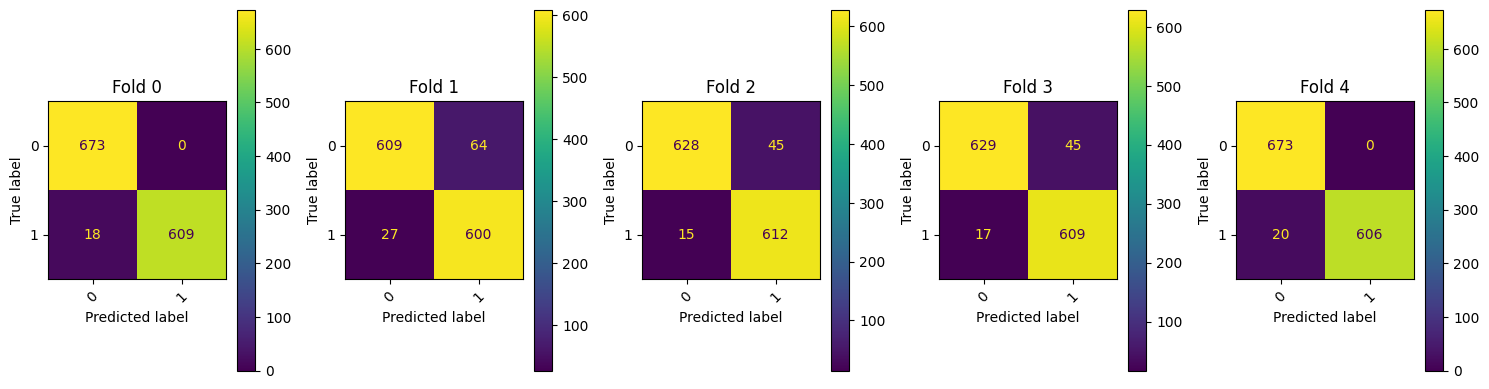

In [12]:
model = OSDT(lamb=0.025, prior_metric="curiosity", saveTree=True)

print(f"Model OSDT with {NUM_FOLD}-fold cross-validation\n")
skf = StratifiedKFold(
    n_splits=NUM_FOLD, shuffle=True, random_state=RANDOM_STATE
)

fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1 = []
fold_mcc = []

hold_out_accuracy = []
hold_out_precision = []
hold_out_recall = []
hold_out_f1 = []
hold_out_mcc = []

tree_stats = []

fig, ax = plt.subplots(1, 5, figsize=(15, 4))
for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
    model.fit(train_X[train_index], train_y[train_index])

    y_pred = model.predict(train_X[test_index])

    acc = accuracy_score(train_y[test_index], y_pred)
    prec = precision_score(train_y[test_index], y_pred, zero_division=0)
    rec = recall_score(train_y[test_index], y_pred)
    f1 = f1_score(train_y[test_index], y_pred)
    mcc = matthews_corrcoef(train_y[test_index], y_pred)
    fold_accuracy.append(acc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)
    fold_mcc.append(mcc)
    print(
        f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Test on hold-out test set
    y_hold_out_pred = model.predict(hold_out_test_X)

    acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
    prec = precision_score(
        hold_out_test_y, y_hold_out_pred, zero_division=0
    )
    rec = recall_score(hold_out_test_y, y_hold_out_pred)
    f1 = f1_score(hold_out_test_y, y_hold_out_pred)
    mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
    hold_out_accuracy.append(acc)
    hold_out_precision.append(prec)
    hold_out_recall.append(rec)
    hold_out_f1.append(f1)
    hold_out_mcc.append(mcc)
    print(
        f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Plot confusion matrix
    cm = confusion_matrix(train_y[test_index], y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm
    )
    disp.plot(ax=ax[i], xticks_rotation=45)
    ax[i].set_title(f"Fold {i}")

    tree_stats.append(compute_tree_metrics(model))

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

print("\nHold-out Test Results:")
print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")


print(f"\nTree stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

plt.tight_layout()

Tree Metrics:
--------------------------------------------------
Number of Branches (Internal Nodes): 4
Maximum Depth: 3
Average Depth: 2.25
Number of Leaves: 4
--------------------------------------------------


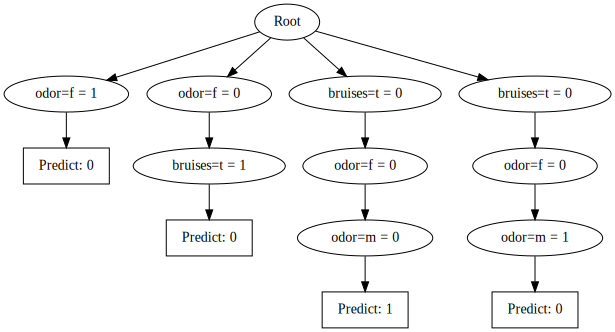

In [13]:
metrics = compute_tree_metrics(model)
print_tree_metrics(model)
dot = visualize_tree(model, feature_names)
dot.render('decision_tree', format='pdf', cleanup=True)
dot